# Bounds

First we need some imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import torchist
import swyft
import pytorch_lightning as pl

## Training data

Now we generate training data.  As simple example, we consider the model

$$
x = z + \epsilon
$$

where the parameter $z \sim \mathcal{N}(\mu = 0, \sigma = 1)$ is standard normal distributed, and $\epsilon \sim \mathcal{N}(\mu = 0, \sigma = 0.1)$ is a small noise contribution.  We are interested in the posterior of $z$ given a measurement of parameter $x$.

In [5]:
class Simulator(swyft.Simulator):
    def __init__(self, bounds = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.z_sampler = swyft.RectBoundSampler(
            [stats.norm(0, 1), stats.uniform(0, 1)],
        bounds = bounds)
        
    def build(self, graph):
        z = graph.node('z', self.z_sampler)
        x = graph.node('x', lambda z: z + np.random.randn(1)*0.1, z)
        
sim = Simulator(bounds = None)

In [6]:
samples = sim.sample(1000)
samples[0]

100%|██████████| 1000/1000 [00:00<00:00, 4393.77it/s]


{'z': array([-0.5017696,  0.6246547], dtype=float32),
 'x': array([-0.46643192,  0.65999234], dtype=float32)}

In [7]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 2, num_params = 2, varnames = 'z')

    def forward(self, A, B):
        logratios = self.logratios(A['x'], B['z'])
        return logratios

## Trainer

Training is now done using the `SwyftTrainer` class, which extends `pytorch_lightning.Trainer` by methods like `infer` (see below).

In [8]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k = 1)
logger = pl.loggers.TensorBoardLogger("./lightning_logs", name = "Test1")
trainer = swyft.SwyftTrainer(accelerator = 'gpu', max_epochs = 3, precision = 64, logger = logger, callbacks = [model_checkpoint])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The `swyft.Samples` class provides convenience functions to generate data loaders for training and validation data.

In [9]:
dm = swyft.SwyftDataModule(samples, fractions = [0.8, 0.02, 0.1], num_workers = 3, batch_size = 8)

In [10]:
network = Network()

In [11]:
trainer.fit(network, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | logratios | LogRatioEstimator_1dim | 34.9 K
-----------------------------------------------------
34.9 K    Trainable params
0         Non-trainable params
34.9 K    Total params
0.280     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [12]:
prior_samples = sim.sample(N = 10000, targets = ['z'])

100%|██████████| 10000/10000 [00:02<00:00, 4886.00it/s]


In [13]:
obs = swyft.Sample(x = np.array([0.3, 0.5]))

In [14]:
logratios = trainer.infer(network, obs, prior_samples)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 109it [00:00, ?it/s]

/home/weniger/miniconda3b/envs/zero/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


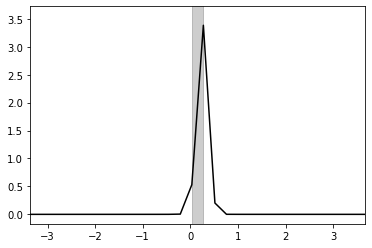

In [15]:
swyft.plot_1d(logratios, "z[0]", ax = plt.gca(), smooth = 0, bins = 30)

In [17]:
bounds = swyft.collect_rect_bounds(logratios, 'z', (2,), threshold = 3e-5)